# Parallel TS Map computation documentation

## Term explanation

### Compton Data Space
Compton data space (CDS) is a 3D space contains three axes:
- Compton scattering angle
- Psi
- Chi

The CDS tells us how the photons are distributed regarding these three properties. For more information about CDS, please refer to the main documentation of data challenge 2.

### Measured data
Measured data is the direct measurements of photons from the detector. It includes both source and background photons. In reality, we are not able to distinguish the source and background photons. But the data we use here are made from simulations, so we are able to seperate them.

### Background model
The background model simply records the background counts at different energies. In reality, we will use certain background models for data anlaysis. But in this tutorial notebook, we will be able to obtain the true background counts since the data are simulated not measured.

### Response
In general, response is a file that records how the detector responses to (measures) the received photons. Because the photon measurement is not perfect, a 3-MeV photon might be measured as a 2.8-MeV photon (or other eneries). Thus, the photons with the same true energy will be dispersed into difference measured energy channels, which is called the energy dipersion. The energy dispersion can be derived from detector response and represented as an energy dispersion (redistribution) matrix.
1. This is a graph of the energy redistribution matrix. The $x$ axis is the incident (true) energy and the $y$ axis is the measured energy.<center>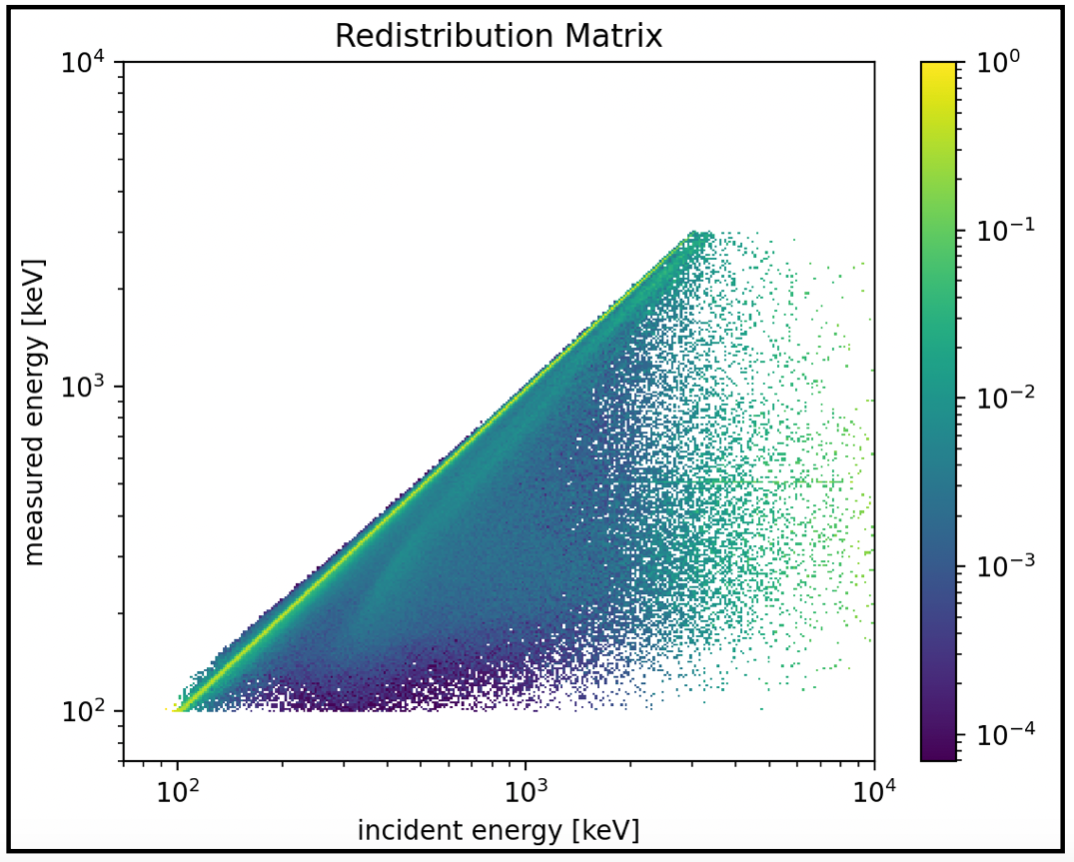</center>
2. If you take a vertical slice (same incident energy), you will be see how the energy is dispersed into the measured energy channels.
3. Response contains more information than just energy. It can also hold distance, Compton scattering angle, etc. I just use energy to demostrate what response is.

The response files are generated by very computationally intensive simulations since we need a massive amount of photons at different energies, incident energies, and other properties like polarization to gain a statistical result. 

## Fast flux and TS Map calculation

Unlike the IR and optical regime, the detector receives $\gamma$-ray photon one by one because of the low flux. This counting experiment makes Possion distribution prefereed statsical model to describe the $\gamma$-ray photons.

### Possion distribution
A discrete random variable $X$ is said to have Poisson distribution, with parameter $\lambda>0$:
$$
f(k;\lambda)=\text{Pr}(X=k)=\frac{\lambda^ke^{-\lambda}}{k!},
$$
where:
- $k$ is the number of occurrences ($k=0,1,2,...$)
- $e$ is the Euler's number
- $\lambda$ is equal to the expectation and variance of $X$: $\lambda=\text{E}(X)=\text{Var}(X)$

### Maximum Poisson log-likelihood ratio test statistic (TS)

Here we will examine two contradictory hypothesis:
- There are non-background photons emitted from a sky location (pixel) with likelihood $L(f)$, where $f$ is the non-background flux.
- There are only background photons emitted from a sky location (pixel) with likelihood $L(0)$, where $f=0$ since no source is present.

The log-likelihood ratio test statistic is defined as:
$$
L L R(f)=2 \log \frac{L(f)}{L(0)}=2 \sum_{i=1}^N \log \frac{P\left(b_i+e_i f, d_i\right)}{P\left(b_i, d_i\right)}
$$
$$
T S=\max L L R(f)=L L R(F)
$$


- $P(\lambda, n)$ is the Poisson probability for n photons with mean $\lambda$ (also called expectation)
    - $\lambda=b_i+e_i f$
        - $b_i$ is the background counts
        - $e_i$ is the expected excess per flux unit, obtained from the detector response
        - $f$ is the free parameter representing the flux from the source
    - $d_i$ is the measured counts data, incluing both source and background photons
    - $F$ is the best estimated flux norm that maxmizes $L L R(f)$

One good news is that $L L R(f)$ has analytic derivatives at all orders. What's more, the second order derivative is always negative. Therefore, $L L R(f)$ has only one maximum, which can be solved by Newton-Raphson's method.
$$
L L R^{\prime}(f)=2 \sum\left(d_i \frac{e_i}{b_i+e_i f}-e_i\right)
$$
$$
L L R^{\prime \prime}(f)=-2 \sum\left(d_i \frac{e_i^2}{\left(b_i+e_i f\right)^2}\right)
$$

### Parallel Computation

The way we generate a TS map is to iterate through all pixels in an all-sky map. Although this in general works, it needs a tremdous amout of time when we want an all-sky map with a good resolution (3072 pixels or higher). A solution to speed it up is to implement parallel computation in our method. The ideal is very simple: **the computation of pixels are independent from each other, thus we can perform the computations together, depending the number of available cpu cores per user.**

Here let me describe the steps in the computation for a single pixel:

#### Step 1: Data Preparation

We need several data files to perform the TS map calculation
- <u>Measured (observational) data</u> in *hd5f* format
- <u>Background model</u> in *hd5f* format
- <u>Response</u> in *h5* format (we have both detector and galactic responses)
- <u>Orientation file</u> in *ori* format (needed when using detector response)
    
With those files we can then:

- Read the all the data files
- Generate a null all-sky map with customized number of pixels
- Choose a pixel from the all-sky map
- Convolve the response with the pixel coordinate and spectrum to get expected excess per flux unit $e_i$

#### Step 2: Data Projection
The data themselves have multiple axes. However, we only need Compton data space on a specific energy range. So will process the data to obtain the portion that needed for the TS map.
- Slice the energy range we want
- Project to Compton data space (CDS).

    Note that CDS is a 3D data space (Compton scattering angle, Psi, and Chi), here I use a 2D slice (PsiChi) to represent CDS in the image below.

#### Steps 3: Newton-Raphson's Method
With the data we obtained from step 2, we will be able to construct the log-likelihood ratio function and find it's global maximum. The returned maximum will be feedback to the pixel we picked as the TS value or the flux nomrm. At this point, the calculation of a pixel is completed.

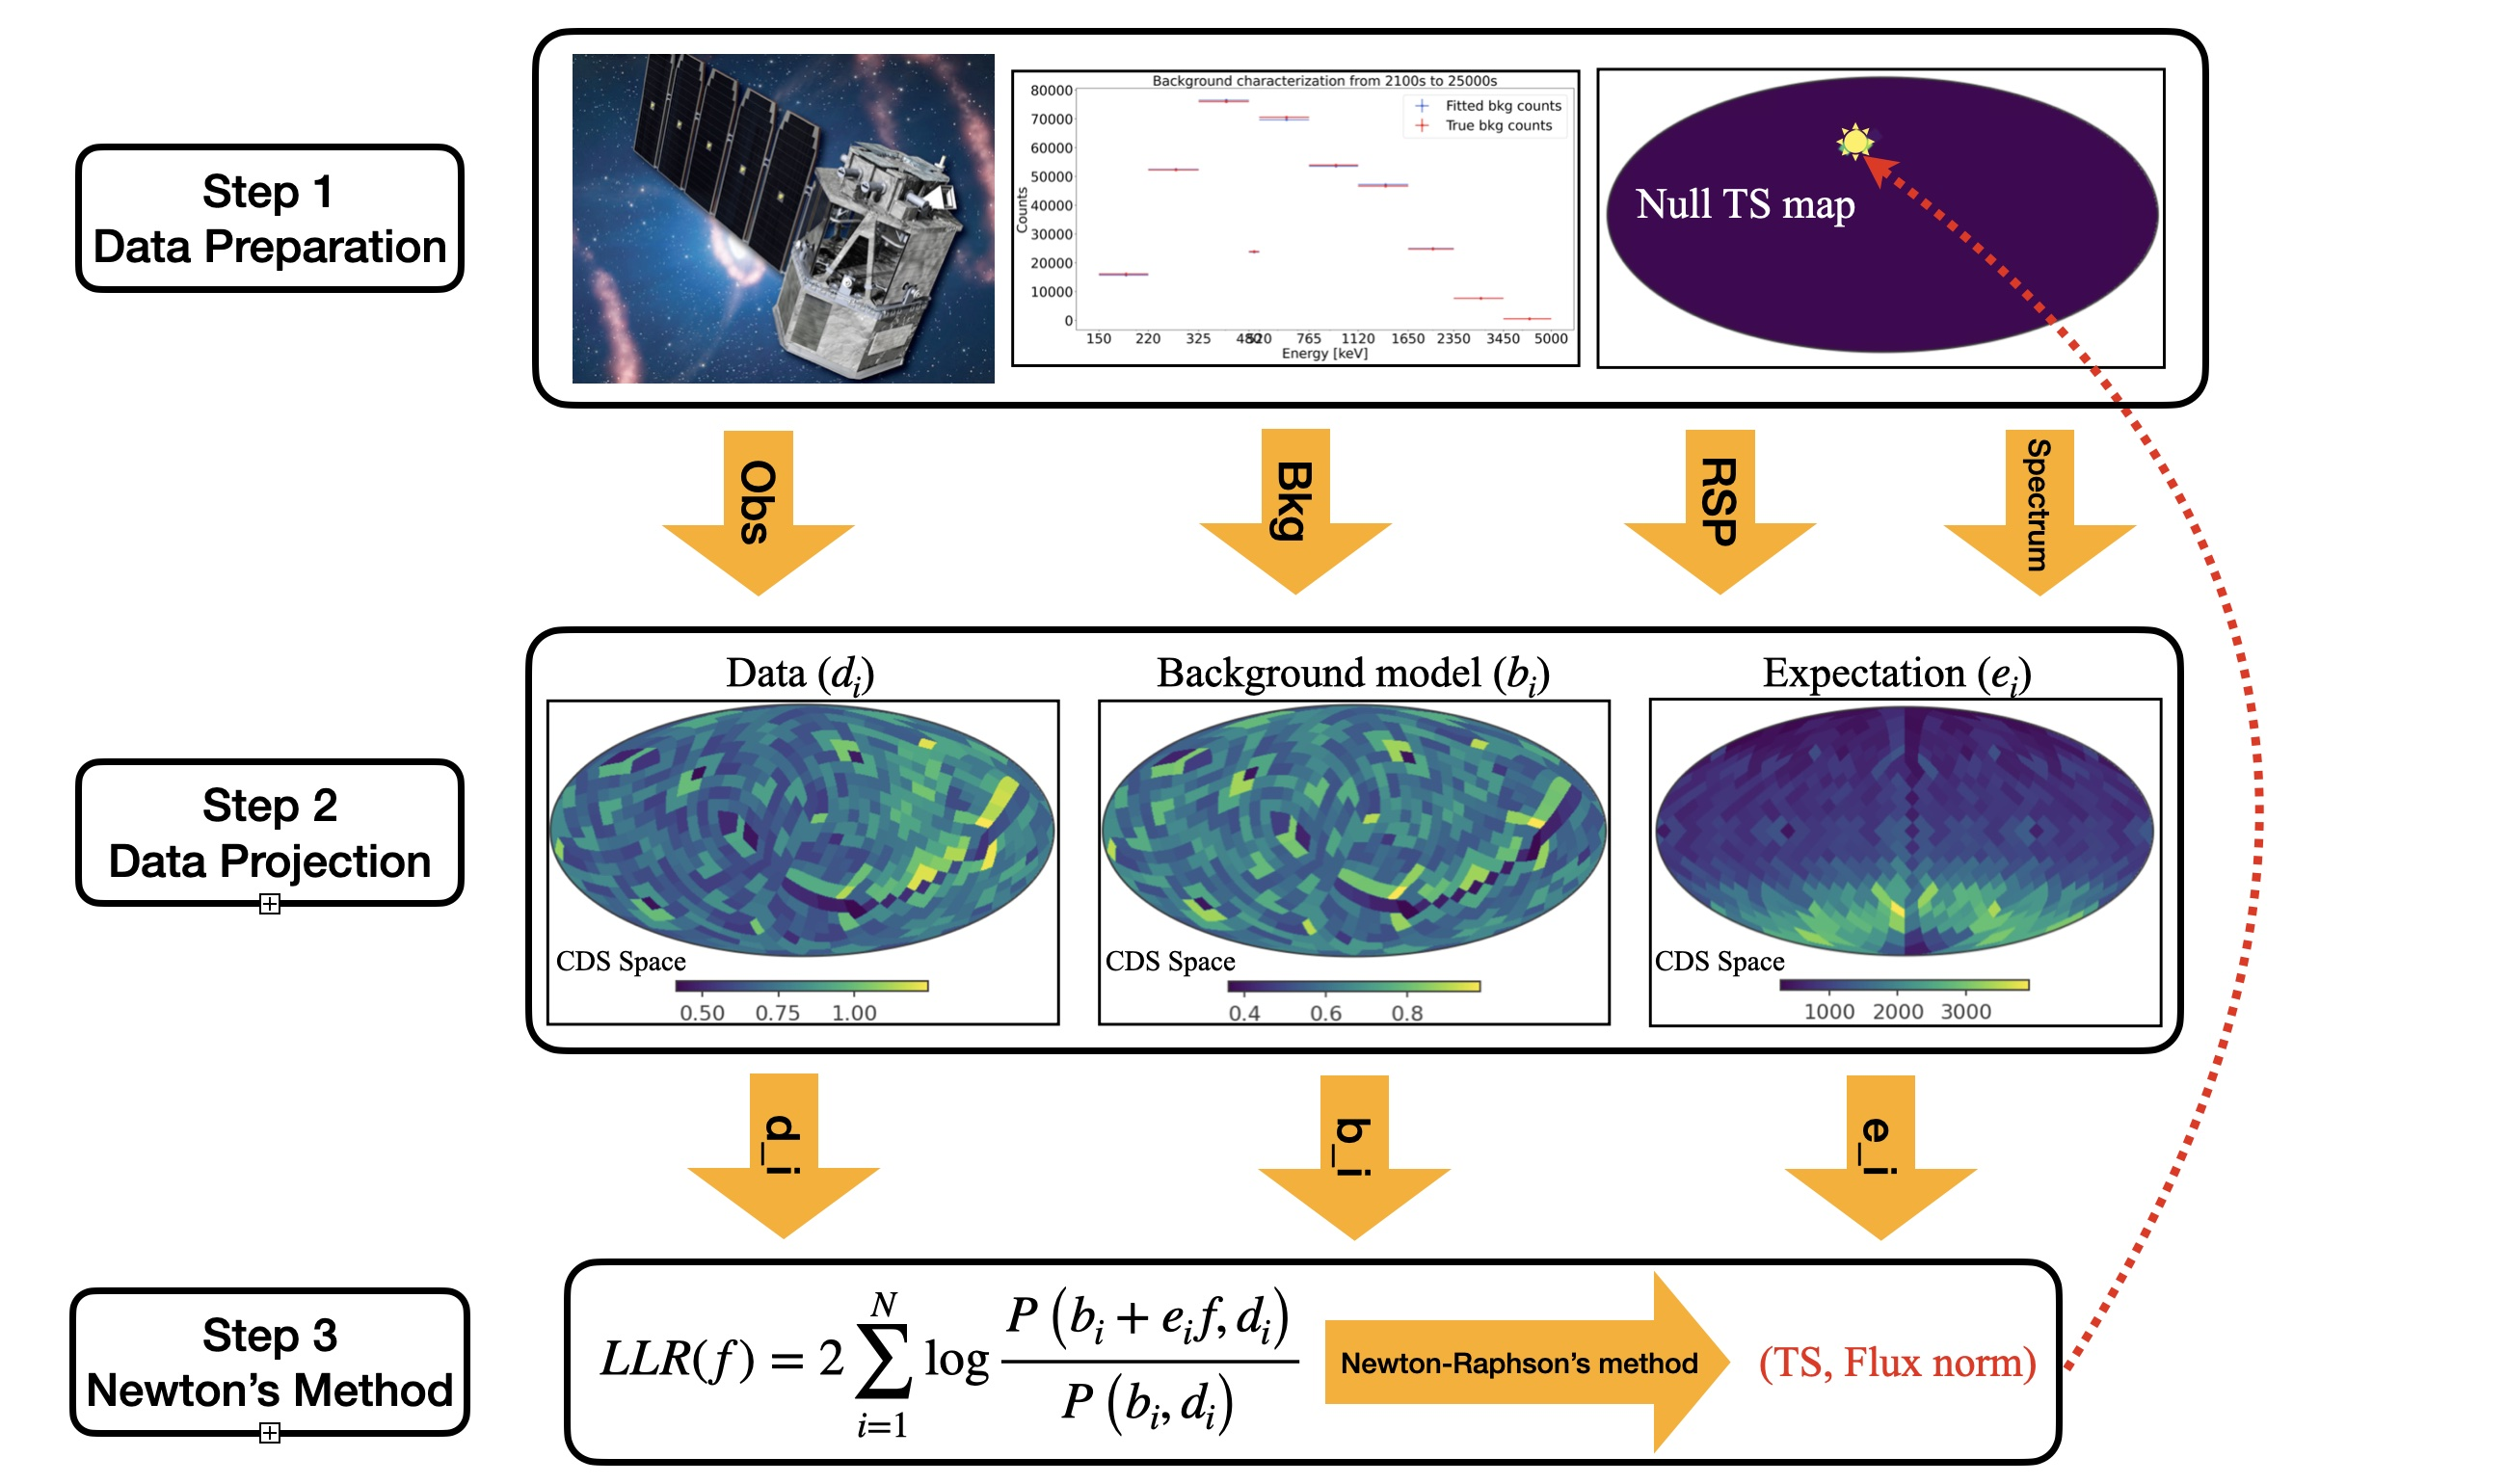

In [ ]:
%%capture
from threeML import Powerlaw
from cosipy import FastTSMap, SpacecraftFile
from cosipy.response import FullDetectorResponse
import astropy.units as u
from histpy import Histogram
from astropy.time import Time
import numpy as np
from astropy.coordinates import SkyCoord
from pathlib import Path
from mhealpy import HealpixMap
from matplotlib import pyplot as plt
import sys

# Fit the GRB using the Compton Data Space (CDS) in local coordinates (Spacecraft frame)

## Define a powerlaw spectrum

In [2]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

## Read data, background model and orientation

In [3]:
# open bkg model

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Bkg_2s_model.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

In [4]:
# Read GRB orientation from file
ori = SpacecraftFile.parse_from_file("../../cosipy/test_data/GRB_Orientation.ori")

## Start TS map fit

In [5]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/Continuum_Flat_100to10000keV_10logEbins_HealPix03.binnedimaging.imagingresponse_nside8.area.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "local", scheme = "RING")

In [6]:
# get a list of hypothesis coordinates to fit. The models will be put on these 
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [7]:
# This is the actual parallel fit
# It uses as much as cores available now  ---> Please let me know if it significantly slow down your machine.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive

ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING")

The time used for the parallel TS map computation is 3.1496909419695536 minutes


## Plot the fitted TS map

In [13]:
ts_array = np.array(ts_results)[:,0:9]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

Text(0.5, 1.0, 'TS Map')

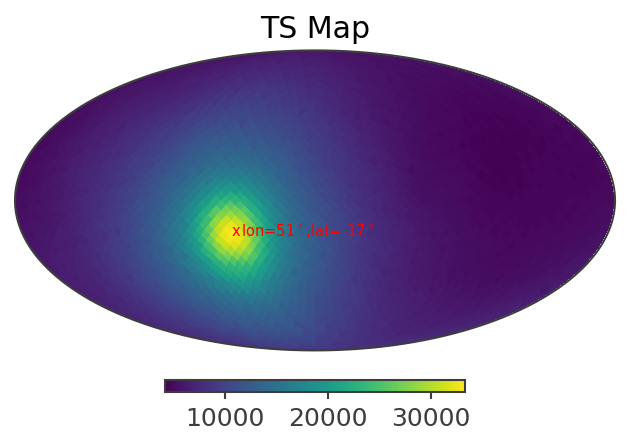

In [14]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("TS Map")

## Plot the iteration map

6.160807291666667


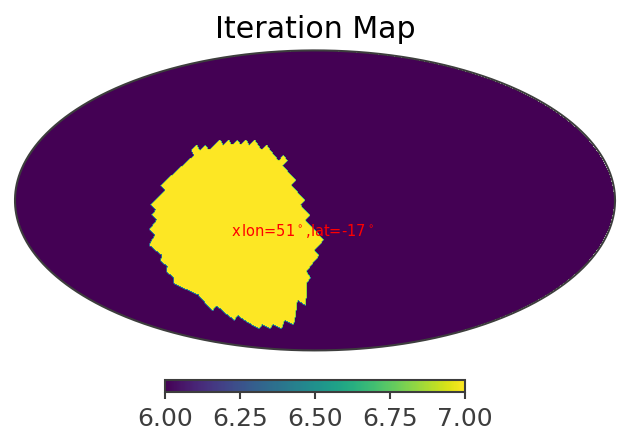

In [23]:
array = ts_array[:,5] # get the array of iteration
avg_iter = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("Iteration Map")
print(avg_iter)

## Plot the elapsed time map

2.0695886713607856


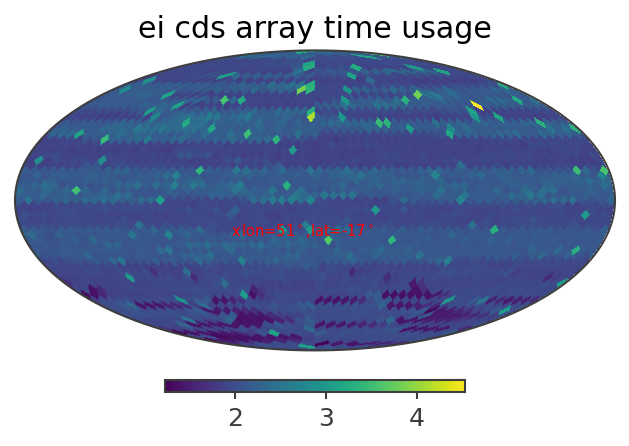

In [26]:
array = ts_array[:,6] # get the array of ei cds time
avg_ei_cds_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("ei cds array time usage")
print(avg_ei_cds_time)

0.193642971261094


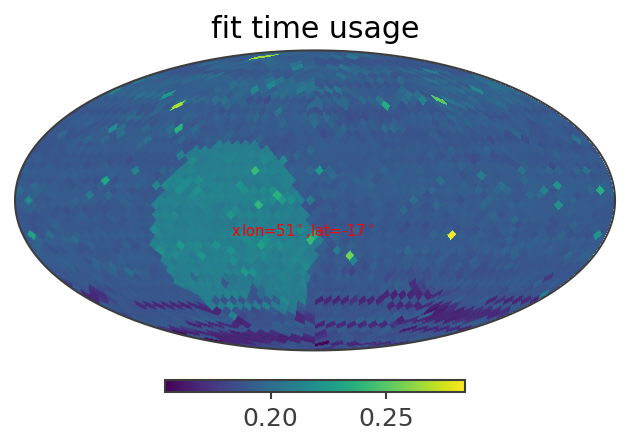

In [27]:
array = ts_array[:,7] # get the array of fit time
avg_fit_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("fit time usage")
print(avg_fit_time)

2.2643727981485426


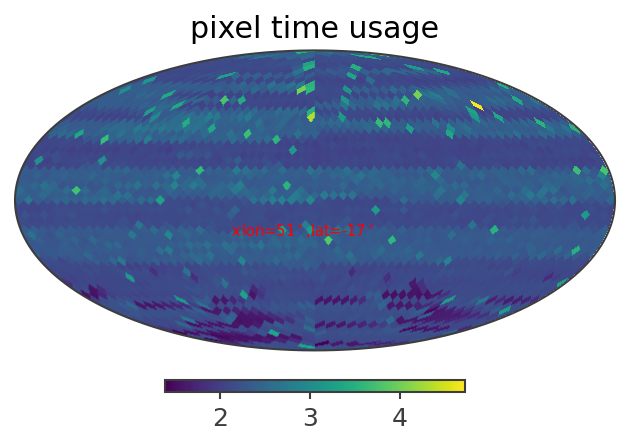

In [29]:
array = ts_array[:,8] # get the array of time per pixel
avg_time_per_pixel = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("pixel time usage")
print(avg_time_per_pixel)

# Fit Crab using the Compton Data Space (CDS) in galactic coordinates

## Process data

In [2]:
# get the binned Crab data
# Because the binned Crab data is too large (~152), so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Sources". If you download the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the Crab data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Sources/crab_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Crab_galactic_CDS",
                         psichi_binning = "galactic")

# After you generate the binned data files, it should be saved to the same directory of this notebook

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [3]:
# get the binned background data
# Because the binned background data is too large (~334M), so it can't be uploaded to GitHub.
# I've uploaded the binned data to wasabi at "COSI-SMEX/DC2/Data/Backgrounds". If you download the binned data file from wasabi, please ignore this cell
# Here is the code I used to bin the background data if you want to generate it by yourself.
from cosipy import BinnedData
# "Crab_bkg_galactic_inputs.yaml" can be used for both Crab and background binning since the only useful information in the yaml file is the binning of CDS
analysis = BinnedData("../../cosipy/test_data/Crab_bkg_galactic_inputs.yaml")
analysis.get_binned_data(unbinned_data="/home/sheng2/astrohe_yong/COSI/cosipy_workshop2023/DC2/Data/Backgrounds/albedo_photons_3months_unbinned_data.fits.gz", 
                         make_binning_plots=False,
                         output_name="Albedo_galactic_CDS",
                         psichi_binning = "galactic")

binning data...
Time unit: s
Em unit: keV
Phi unit: deg
PsiChi unit: None


In [22]:
# open bkg model

bkg_model = Histogram.open("Albedo_galactic_CDS.hdf5")  # please make sure you adjust the path to the files by yourself.
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("Crab_galactic_CDS.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

# here the background added to the source is the same as the bkg model since they are simulations, thus we know the background very well.
bkg_original = Histogram.open("Albedo_galactic_CDS.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

#del data_used

Text(0, 0.5, 'Counts')

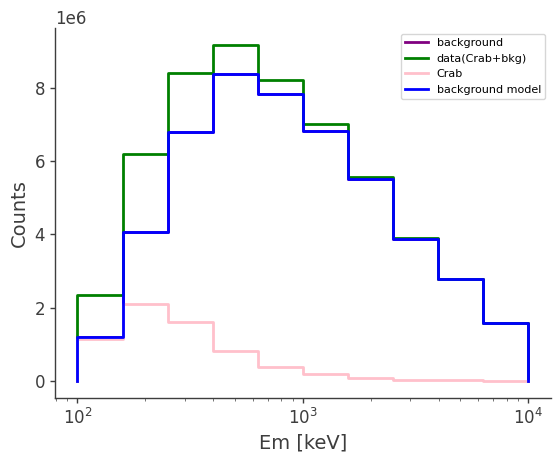

In [5]:
# plot the counts distribution
ax,plot = bkg.project("Em").draw(label = "background", color = "purple")
#data.project("Em").draw(ax, label = "data", color = "green")
data_used.project("Em").draw(ax, label = "data(Crab+bkg)", color = "green")
signal.project("Em").draw(ax, label = "Crab", color = "pink")
bkg_model.project("Em").draw(ax, label = "background model", color = "blue")

ax.legend()
ax.set_xscale("log")
ax.set_ylabel("Counts")

## Start TS map fit

In [30]:
# define a powerlaw spectrum
index = -3
K = 10**-3 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV

spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

In [31]:
# the response file is available on wasabi  --> Please let me know if you need the command line to download it
response_path = Path("/zfs/astrohe/yong/COSI/cosipy_workshop2023/DC2/Responses/PointSourceReponse/psr_gal_DC2.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [32]:
# get a list of hypothesis coordinates to fit. The model will be put on these coordinates to generated the expected counts
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [33]:
# This is the actual parallel fit
# You can configure the number of cores now.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [1,2], spectrum = spectrum, ts_scheme = "RING", cpu_cores = 40)

The time used for the parallel TS map computation is 0.5797204852104187 minutes


## Plot results

In [34]:
ts_array = np.array(ts_results)[:,0:9]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

Text(184.5551, -5.7877, '   Crab')

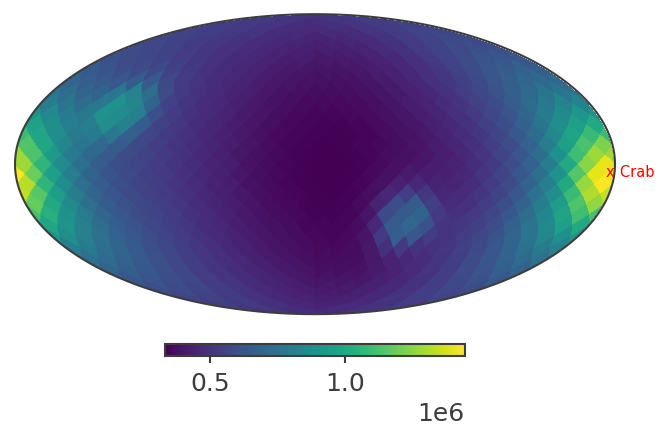

In [35]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
ax.text(184.5551, -05.7877, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(184.5551, -05.7877, fr"   Crab", size = 7, transform = ax.get_transform('galactic'), color = "red")

## Plot the iteration map

4.947916666666667


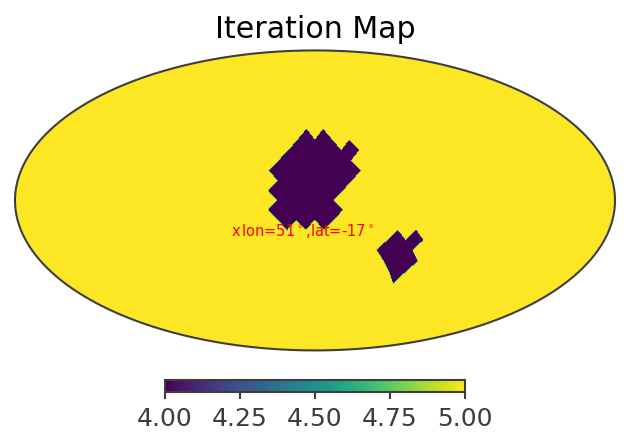

In [36]:
array = ts_array[:,5] # get the array of iteration
avg_iter = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("Iteration Map")
print(avg_iter)

## Plot the elapsed time map

0.14726191953135034


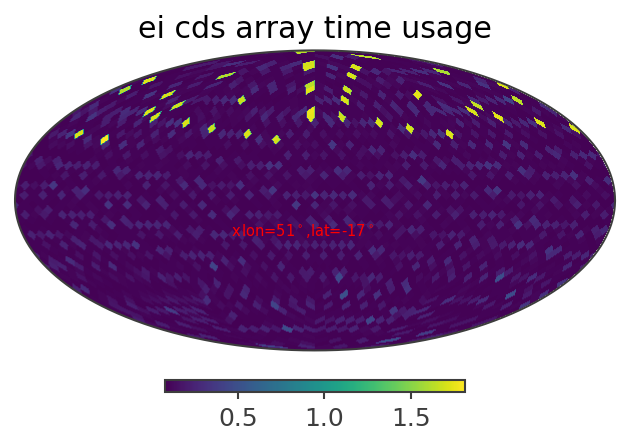

In [37]:
array = ts_array[:,6] # get the array of ei cds time
avg_ei_cds_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("ei cds array time usage")
print(avg_ei_cds_time)

0.2639058045266817


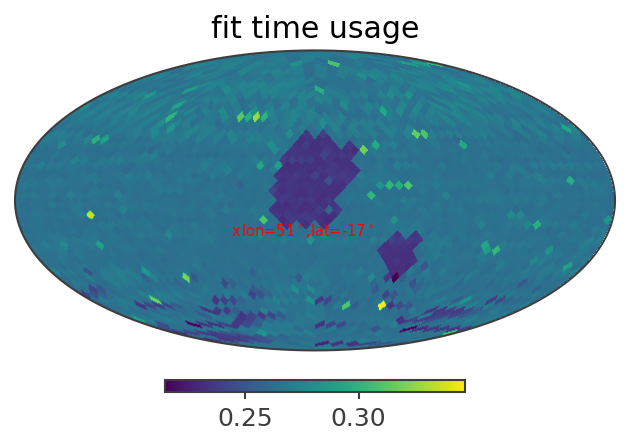

In [38]:
array = ts_array[:,7] # get the array of fit time
avg_fit_time = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("fit time usage")
print(avg_fit_time)

0.4120916190246741


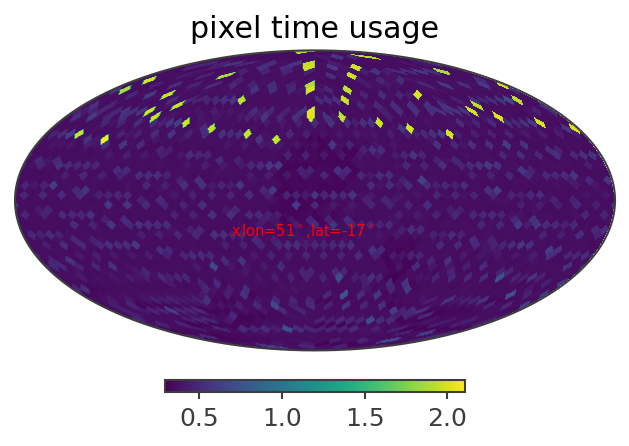

In [39]:
array = ts_array[:,8] # get the array of time per pixel
avg_time_per_pixel = array.mean()
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, "x", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.text(lon, lat, fr"  lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")
ax.set_title("pixel time usage")
print(avg_time_per_pixel)

# Fit the GRB using the Compton Data Space (CDS) in galactic coordinates
## **NOTE: This is deprecated, do not run. Keep it for reference if needed in the furture.**

## Define a powerlaw spectrum

In [26]:
# define a powerlaw spectrum
index = -2.2
K = 10 / u.cm / u.cm / u.s / u.keV
piv = 100 * u.keV
spectrum = Powerlaw()
spectrum.index.value = index
spectrum.K.value = K.value
spectrum.piv.value = piv.value 
spectrum.K.unit = K.unit
spectrum.piv.unit = piv.unit

## Read data, background model and orientation

In [28]:
# open bkg model

bkg_model = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2hr_galactic.hdf5")
bkg_model = bkg_model.project(['Em', 'PsiChi', 'Phi'])/3600

# read the signal and bkg to assemble data = bkg + signal
signal_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_protoGRB_galactic.hdf5")
signal = signal_original.project(['Em', 'PsiChi', 'Phi'])

bkg_original = Histogram.open("../../cosipy/test_data/new_healpix_rsp_Binned_Cosmic2s_galactic.hdf5")
bkg = bkg_original.project(['Em', 'PsiChi', 'Phi'])

signal = 1*signal
data_used = bkg + signal

In [29]:
# get orientation
# Note this orientation is hard-coded for this specific GRB

time = Time(np.array([1835481433.0, 1835481433.5, 1835481434.0, 1835481434.5, 1835481435.0]), format="unix")

x_pointings = SkyCoord(b=[53.30823215719789, 53.30823215719789, 53.25629494101732, 53.25629494101732, 53.20436773279772]*u.deg,
                       l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg,
                       frame = "galactic")

z_pointings = SkyCoord(l = [51.00102125784474, 51.00102125784474, 51.035133117383225, 51.035133117383225, 51.0692916774301]*u.deg, 
                       b = [-36.69176784280211, -36.69176784280211, -36.74370505898268, -36.74370505898268, -36.79563226720228]*u.deg,
                       frame = "galactic")

ori = SpacecraftFile(time = time, x_pointings = x_pointings, z_pointings = z_pointings)

## Start TS map fit

In [30]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

# here let's create a FastTSMap object
ts = FastTSMap(data = data_used, bkg_model = bkg_model, orientation = ori, 
               response_path = response_path, cds_frame = "galactic", scheme = "RING")

In [31]:
# get a list of hypothesis coordinates to fit. The models will be put on these coordinates
# note that this nside is also the nside of the final TS map
hypothesis_coords = FastTSMap.get_hypothesis_coords(nside = 16)

In [32]:
# This is the actual parallel fit
# It uses as much as cores available now  ---> Please let me know if it significantly slow down your machine.
# energy channel is [lower_channel, upper_channel]. Lower channel is inclusive while the upper channel is exclusive
ts_results = ts.parallel_ts_fit(hypothesis_coords = hypothesis_coords, energy_channel = [2,3], spectrum = spectrum, ts_scheme = "RING")

The time used for the parallel TS map computation is 1.798968990643819 minutes


## Plot the fitted TS map

In [33]:
ts_results

[[0, 13473.45513282079, 52.3137819622534, 0.6184566698227567, False],
 [1, 14494.938129905122, 52.650367946184694, 0.6005827799828138, False],
 [2, 13922.714507784138, 57.1367537417465, 0.662580718684385, False],
 [3, 13581.741295027141, 53.607919681340405, 0.6282670462104164, False],
 [4, 14452.396442043791, 47.67079912267055, 0.5445046510748227, False],
 [5, 14652.367706005198, 50.16977798236057, 0.5698078056989412, False],
 [6, 14683.019362837904, 47.4111843423496, 0.5370501830670581, False],
 [7, 13998.066579799979, 53.532814424942316, 0.6184299784171252, False],
 [8, 13127.690870202796, 58.1758768486784, 0.6946478598729957, False],
 [9, 13581.741295027141, 53.607919681340405, 0.6282670462104164, False],
 [10, 12409.394880398164, 50.51642617551018, 0.6190163291040264, False],
 [11, 13986.893165238209, 47.20509582684049, 0.5465246150324277, False],
 [12, 14130.464170463156, 41.358527397600426, 0.4791737067003087, False],
 [13, 14882.483124059241, 38.92659479281741, 0.439236781252618

In [34]:
ts_array = np.array(ts_results)[:,0:2]  # get the pix number and TS value column
ts_array = ts_array[ts_array[:, 0].argsort()]  # arrange the row by the pix number to make sure the ts values are ordered correctly

In [35]:
ts_array

array([[0.00000000e+00, 1.34734551e+04],
       [1.00000000e+00, 1.44949381e+04],
       [2.00000000e+00, 1.39227145e+04],
       ...,
       [3.06900000e+03, 1.19660428e+04],
       [3.07000000e+03, 1.17616171e+04],
       [3.07100000e+03, 1.20405097e+04]])

Text(51, -17, '⬋here lon=51$^\\circ$,lat=-17$^\\circ$')

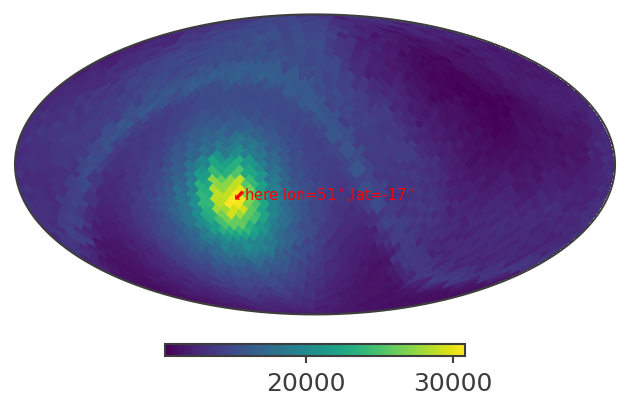

In [36]:
array = ts_array[:,1] # get the array of ts value
m = HealpixMap(data = array, scheme = "RING", dtype = float, coordsys = "G")
plot, ax = m.plot(ax_kw = {'coord':'G'})
lon = 51
lat = -17
ax.text(lon, lat, fr"⬋here lon={lon}$^\circ$,lat={lat}$^\circ$", size = 7, transform = ax.get_transform('galactic'), color = "red")

# Some tests

## Check scatt_map

In [15]:
response_path = Path("/home/sheng2/astrohe_yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5")

with FullDetectorResponse.open(response_path) as response:
    
    scatt_map = ori.get_scatt_map(nside = response.nside, coordsys = 'galactic')
    

(<MollviewSubplot: >, <matplotlib.image.AxesImage at 0x14b6ae330130>)

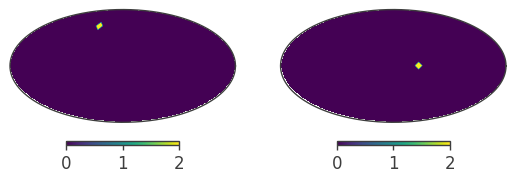

In [16]:
fig,axes = plt.subplots(ncols = 2, subplot_kw = {'projection':'mollview', 'coord':'G'})

scatt_map.project('x').plot(axes[0])
scatt_map.project('y').plot(axes[1])

## Check ei

In [17]:
ei_cds_array = FastTSMap.get_ei_cds_array(hypothesis_coord = hypothesis_coords[233], cds_frame = "galactic",
                                          energy_channel = [2,3], orientation = ori, 
                                          response_path = response_path, spectrum = spectrum)

In [18]:
ei_cds_array.shape

(27648,)

In [20]:
FastTSMap.get_cds_array(data_used, [2,3]).shape

(23040,)

In [21]:
FastTSMap.get_cds_array(bkg_model, [2,3]).shape

(23040,)

In [30]:
with FullDetectorResponse.open(response_path) as response:
    print(repr(response))

FILENAME: '/zfs/astrohe/yong/COSI/Response/SMEXv12.Continuum.HEALPixO3_10bins_log_flat.binnedimaging.imagingresponse.nonsparse_nside8.area.good_chunks_unzip.h5'
AXES:
  NuLambda:
    DESCRIPTION: 'Location of the simulated source in the spacecraft coordinates'
    TYPE: 'healpix'
    NPIX: 768
    NSIDE: 8
    SCHEME: 'RING'
  Ei:
    DESCRIPTION: 'Initial simulated energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Em:
    DESCRIPTION: 'Measured energy'
    TYPE: 'log'
    UNIT: 'keV'
    NBINS: 10
    EDGES: [100.0 keV, 158.489 keV, 251.189 keV, 398.107 keV, 630.957 keV, 1000.0 keV, 1584.89 keV, 2511.89 keV, 3981.07 keV, 6309.57 keV, 10000.0 keV]
  Phi:
    DESCRIPTION: 'Compton angle'
    TYPE: 'linear'
    UNIT: 'deg'
    NBINS: 36
    EDGES: [0.0 deg, 5.0 deg, 10.0 deg, 15.0 deg, 20.0 deg, 25.0 deg, 30.0 deg, 35.0 deg, 40.0 de

In [28]:
768*30

23040